## Overview

Xarray is an evolution of rasterio and is inspired by libraries like pandas to work with raster datasets. It is particularly suited for working with multi-dimensional time-series raster datasets. It also integrates tightly with dask that allows one to scale raster data processing using parallel computing. XArray provides [Plotting Functions](https://xarray.pydata.org/en/stable/user-guide/plotting.html) based on Matplotlib.

In this section, we will learn about XArray basics and learn how to work with a time-series of Sentinel-2 satellite imagery to create and visualize a median composite image.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac-client odc-stac rioxarray

In [ ]:
import os
import matplotlib.pyplot as plt
import pystac_client
from odc.stac import stac_load
import xarray as xr
import rioxarray as rxr

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

## Get Satellite Imagery using STAC API

We define a location and time of interest to get some satellite imagery.

In [ ]:
latitude = 27.163
longitude = 82.608
year = 2023

Let's use Element84 search endpoint to look for items from the sentinel-2-l2a collection on AWS.

In [ ]:
catalog = pystac_client.Client.open(
    'https://earth-search.aws.element84.com/v1')

# Define a small bounding box around the chosen point
km2deg = 1.0 / 111
x, y = (longitude, latitude)
r = 1 * km2deg  # radius in degrees
bbox = (x - r, y - r, x + r, y + r)

search = catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime=f'{year}',
    query={'eo:cloud_cover': {'lt': 30}},
)
items = search.item_collection()

Load the matching images as a XArray Dataset.

In [ ]:
ds = stac_load(
    items,
    bands=['red', 'green', 'blue', 'nir'],
    resolution=10,
    bbox=bbox,
    chunks={},  # <-- use Dask
    groupby='solar_day',
)
ds

In [ ]:
%%time
ds = ds.compute()

## XArray Terminology

We now have a `xarray.Dataset` object. Let's understand what is contained in a Dataset.

* *Variables*: This is similar to a band in a raster dataset. Each variable contains an array of values.
* *Dimensions*: This is similar to number of array axes.
* *Coordinates*: These are the labels for values in each dimension.
* *Attributes*: This is the metadata associated with the dataset.

<img src='https://courses.spatialthoughts.com/images/python_dataviz/xarray_terminology.png' width=800/>

A Dataset consists of one or more `xarray.DataArray` object. This is the main object that consists of a single variable with dimension names, coordinates and attributes. You can access each variable using `dataset.variable_name` syntax.

In [ ]:
da = ds.red
da

## Selecting Data

XArray provides a very powerful way to select subsets of data, using similar framework as Pandas. Similar to Panda's `loc` and `iloc` methods, XArray provides `sel` and `isel` methods. Since DataArray dimensions have names, these methods allow you to specify which dimension to query.

Let's select the temperature anomany values for the last time step. Since we know the index (-1) of the datam we can use `isel` method.

In [ ]:
da.isel(time=-1)

You can call `.values` on a DataArray to get an array of the values.

In [ ]:
da.isel(time=-1).values

You can query for a values at using multiple dimensions.

In [ ]:
da.isel(time=-1, x=-1, y=-1).values

We can also specify a value to query using the `sel()` method.

Let's see what are the values of `time` variable.

In [ ]:
dates = da.time.values
dates

We can query using the value of a coordinate using the `sel()` method.

In [ ]:
da.sel(time='2023-12-16')

The `sel()` method also support nearest neighbor lookups. This is useful when you do not know the exact label of the dimension, but want to find the closest one.

> Tip: You can use `interp()` instead of `sel()` to interpolate the value instead of closest lookup.

In [ ]:
da.sel(time='2023-01-01', method='nearest')

The `sel()` method also allows specifying range of values using Python's built-in `slice()` function. The code below will select all observations during January 2023.

In [ ]:
da.sel(time=slice('2023-01-01', '2023-01-31'))

## Aggregating Data

A very-powerful feature of XArray is the ability to easily aggregate data across dimensions - making it ideal for many remote sensing analysis. Let's create a median composite from all the individual images.

We apply the `.median()` aggregation across the `time` dimension.

In [ ]:
median = ds.median(dim='time')
median

## Visualizing Data

XArray provides a `plot.imshow()` method based on Matplotlib to plot DataArrays.

Reference : [xarray.plot.imshow ](https://docs.xarray.dev/en/stable/generated/xarray.plot.imshow.html)

To visualize our Dataset, we first convert it to a DataArray using the `to_array()` method. All the variables will be converted to a new dimension. Since our variables are image bands, we give the name of the new dimesion as `band`.

In [ ]:
median_da = median.to_array('band')
median_da

The easy way to visualize the data without the outliers is to pass the parameter `robust=True`. This will use the 2nd and 98th percentiles of the data to compute the color limits.

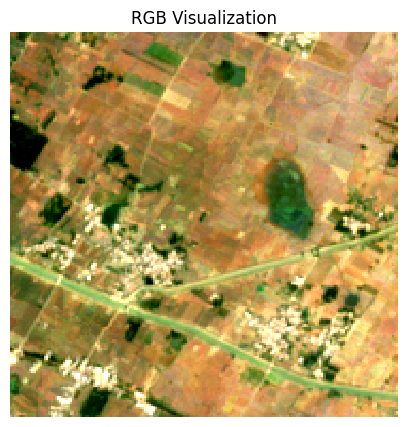

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
median_da.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

## Exercise

Display the median composite for the month of May.

The snippet below takes our time-series and aggregate it to a monthly median composites `groupby()` method.

In [ ]:
monthly = ds.groupby('time.month').median(dim='time')
monthly

You now have a new dimension named `month`. Start your exercise by first converting the Dataset to a DataArray. Then extract the data for the chosen month using `sel()` method and plot it.